In [1]:
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from random import randint

In [2]:
def build_tfidf(guidelines: list[str], pca_component=100):
    # Preprocess all documents (prior to building the vocabulary)
    corpus = []

    print(' - Proprocess and extract the corpus')
    for guideline in tqdm(guidelines):
        text = guideline["text"]

        # Replacing unconventional punctuation with spaces
        text = re.sub(r'[\(\)\[\]\,\-\;\.\!\?”“\"\']', ' ', text)
        text = re.sub(r'[\*+\_\#]+', ' ', text)
        text = re.sub(r'\s+', ' ', text)

        # Stemming is done by sklearn
        corpus.append(text)
    
    # Build the vocabulary matrix
    print(' - Vectorize the corpus')
    vectorizer = CountVectorizer(min_df=0.01, max_df=0.9, token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b") # Must be less that 80%
    counts = vectorizer.fit_transform(corpus).toarray()

    # Learn the IDF matrix
    print(' - Learn the IDF for each terms')
    transformer = TfidfTransformer(use_idf=False)
    transformer.fit(counts)

    # Build the TF-IDF matrix for each sample of the corpus
    print(' - Build the TF-IDF dense matrix')
    tfidf = transformer.transform(counts + 1).toarray() # Smoothing of the count

    # Running PCA on tf-idf matrix to select the important words
    pca = PCA(n_components=pca_component)
    pca.fit(tfidf)

    # Finally transform the tfidf matrix into a smaller collection
    compact_tfidf = pca.transform(tfidf)
    return compact_tfidf, pca, transformer, vectorizer

In [7]:
GUIDELINE_PATH = join('..', 'data', 'knowledge_database', 'guidelines', 'structured_guidelines')

In [14]:
# Retrieve all guidelines
print(' - Retrieving guidelines')
guidelines = []
for file in listdir(GUIDELINE_PATH):
    path = join(GUIDELINE_PATH, file)

    if path.endswith('.jsonl'):
        with open(path, 'r') as f:
            guidelines += [x for x in list(map(json.loads, f.readlines())) if 'label' in x]
# guidelines = guidelines[:5000]

 - Retrieving guidelines


In [15]:
[g['label'] for g in guidelines if 'astronomy' in g['label']]

[]

In [17]:
# Preprocess all documents (prior to building the vocabulary)
corpus = []

print(' - Proprocess and extract the corpus')
for guideline in tqdm(guidelines):
    text = guideline["structure"]

    # Replacing unconventional punctuation with spaces
    text = re.sub(r'[\(\)\[\]\,\-\;\.\!\?”“\"\']', ' ', text)
    text = re.sub(r'[\*+\_\#]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Stemming is done by sklearn
    corpus.append(text)

 - Proprocess and extract the corpus


  0%|          | 0/1315 [00:00<?, ?it/s]

{'label': 'Iron Deficiency Anemia in Young Children', 'Symptoms list': ['No symptoms mentioned in the given recommendation.'], 'Contextual info': {'Factors affecting diagnostic': ['The evidence is insufficient to assess the balance of benefits and harms of screening. The performance of risk assessment tools to identify children who are at increased risk for iron deficiency anemia has not been studied.']}}


TypeError: expected string or bytes-like object

In [23]:
# Load dictionary from the file
with open("medic_dictionary.json", "r") as f:
    dictionary = json.load(f)

terms = list(set(x for x in ' '.join([x.replace('-', ' ').lower() for x in dictionary.keys()]).split(' ') if len(x) > 0))
terms[:5]

['tricyclic', 'degenerative', 'plexus', 'leukotriene', 'contractile']

In [24]:
# Build the vocabulary matrix
print(' - Vectorize the corpus')
vectorizer = CountVectorizer(token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b", vocabulary=terms) # Must be less that 80%
counts = vectorizer.fit_transform(corpus).toarray()
print(counts.shape)

 - Vectorize the corpus
(42336, 2219)


In [28]:
transformer = TfidfTransformer(use_idf=False)
transformer.fit(counts)

# Build the TF-IDF matrix for each sample of the corpus
print(' - Build the TF-IDF dense matrix')
tfidf = transformer.transform(counts + 1).toarray() # Smoothing of the count

 - Build the TF-IDF dense matrix


In [59]:
def distance(d1, d2):
    a = np.linalg.norm(tfidf[d1, :])
    b = np.linalg.norm(tfidf[d2, :])
    return np.arccos(np.dot(a, b))

def distance2(d1, d2):
    a = tfidf[d1, :]
    b = tfidf[d2, :]
    return np.sum((a - b)**2)


N1 = randint(0, compact_idf.shape[0] - 1)
bN2 = None
bScore = 0
N = 0

for i in range(10000):
    N2 = randint(0, compact_idf.shape[0] - 1)
    if N2 != N1:
        nScore = distance2(N1, N2)
        if bN2 is None or nScore < bScore:
            bScore = nScore
            bN2 = N2
            N += 1

print('N1: {}'.format(guidelines[N1]['title']))
print('N2: {}'.format(guidelines[bN2]['title']))
print('score: {}'.format(bScore))
print('#update: {}'.format(N))

N1: Atomic radiation astronomy
N2: Neutrino radiation astronomy
score: 0.016823362435065253
#update: 13


In [39]:
sort = np.argsort(-np.abs(Y), axis=1)
sort = sort[:, :5]

for i in range(5):
    print('============================== FEATURE {} =============================='.format(i))
    M = sort[i, :]
    yy = Y[i, M]
    names = vectorizer.get_feature_names_out()[M]
    print('\n'.join('{:<30}: {}'.format(name, p) for name, p in zip(names, yy)))

    MID = np.argsort(-np.abs(compact_idf[:, i]))[:5]
    print('; '.join([guidelines[x]['title'] for x in MID]))

NameError: name 'Y' is not defined

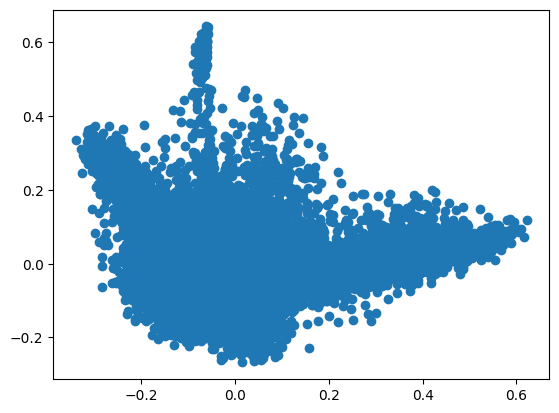

In [209]:
A, B = compact_idf.T[2, :], compact_idf.T[3, :]
plt.scatter(A, B)